In [1]:
# 1. Imports and Configuration
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt


DATA_DIR = r"C:\Users\HP\Desktop\Brain_tumor_predictionn\brainMRI_data"
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
VAL_DIR = os.path.join(DATA_DIR, "Validation")
TEST_DIR = os.path.join(DATA_DIR, "Testing")

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-3
NUM_CLASSES = 4
MODEL_PATH = "custom_cnn.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# 2. Data Transforms and Loaders

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
val_dataset   = datasets.ImageFolder(VAL_DIR, transform=transform)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
#  3. Custom CNN Model

class CustomCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CustomCNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),   # [B, 16, 224, 224]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # [B, 16, 112, 112]

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # [B, 32, 56, 56]

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # [B, 64, 28, 28]

            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.network(x)

model = CustomCNN().to(device)



In [4]:
# 4. Train Function with Time + Validation Accuracy

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

def train_model(model, train_loader, val_loader):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0

    for epoch in range(EPOCHS):
        start = time.time()
        model.train()
        total_loss = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_acc = evaluate(model, val_loader)
        end = time.time()

        print(f" Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.3f} | Val Acc: {val_acc:.2f}% | Time: {end-start:.1f}s")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), MODEL_PATH)
            print("Best model saved!")

train_model(model, train_loader, val_loader)


Epoch 1/10: 100%|██████████| 286/286 [01:32<00:00,  3.08it/s]


 Epoch 1/10 | Loss: 204.145 | Val Acc: 81.24% | Time: 107.8s
Best model saved!


Epoch 2/10: 100%|██████████| 286/286 [01:28<00:00,  3.22it/s]


 Epoch 2/10 | Loss: 121.105 | Val Acc: 85.10% | Time: 101.5s
Best model saved!


Epoch 3/10: 100%|██████████| 286/286 [01:30<00:00,  3.15it/s]


 Epoch 3/10 | Loss: 79.935 | Val Acc: 91.85% | Time: 103.5s
Best model saved!


Epoch 4/10: 100%|██████████| 286/286 [01:31<00:00,  3.14it/s]


 Epoch 4/10 | Loss: 49.120 | Val Acc: 92.46% | Time: 104.0s
Best model saved!


Epoch 5/10: 100%|██████████| 286/286 [01:31<00:00,  3.13it/s]


 Epoch 5/10 | Loss: 36.244 | Val Acc: 93.16% | Time: 104.4s
Best model saved!


Epoch 6/10: 100%|██████████| 286/286 [01:32<00:00,  3.10it/s]


 Epoch 6/10 | Loss: 26.945 | Val Acc: 92.73% | Time: 105.2s


Epoch 7/10: 100%|██████████| 286/286 [01:34<00:00,  3.02it/s]


 Epoch 7/10 | Loss: 20.755 | Val Acc: 92.81% | Time: 107.8s


Epoch 8/10: 100%|██████████| 286/286 [01:34<00:00,  3.04it/s]


 Epoch 8/10 | Loss: 18.023 | Val Acc: 93.51% | Time: 107.0s
Best model saved!


Epoch 9/10: 100%|██████████| 286/286 [01:33<00:00,  3.07it/s]


 Epoch 9/10 | Loss: 9.205 | Val Acc: 92.73% | Time: 106.5s


Epoch 10/10: 100%|██████████| 286/286 [01:37<00:00,  2.94it/s]


 Epoch 10/10 | Loss: 11.192 | Val Acc: 92.81% | Time: 110.8s


In [5]:
# 5. Load Best Model and Test Evaluation

model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)
test_acc = evaluate(model, test_loader)
print(f" Test Accuracy: {test_acc:.2f}%")


 Test Accuracy: 95.19%



 Test Accuracy: 95.19%

 Classification Report:
              precision    recall  f1-score   support

      glioma       0.92      0.94      0.93       300
  meningioma       0.92      0.88      0.90       306
     notumor       0.98      0.98      0.98       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



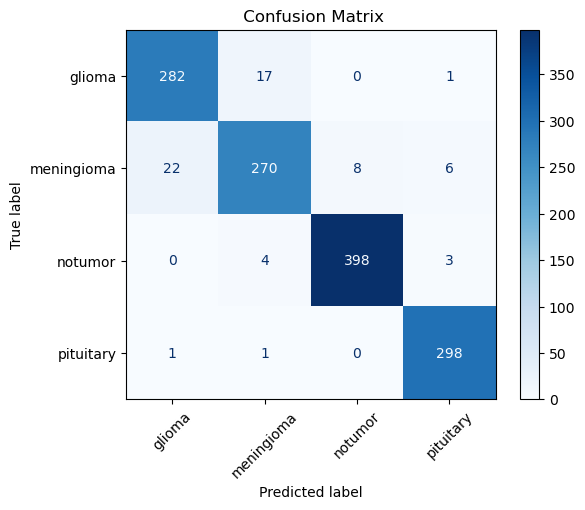

In [6]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

#  Step 1: Load the Model
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)
model.eval()

# Step 2: Get Predictions and True Labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Step 3: Evaluate Accuracy
test_acc = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
print(f"\n Test Accuracy: {test_acc:.2f}%")

# Step 4: Classification Report
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Step 5: Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title(" Confusion Matrix")
plt.show()
